### Непараметрические критерии (Одновыборочные)
Начнем с **одновыборочных** задач и поприменяем **знаковые, ранговые и перестановачные критерии.**

16 лабораторных мышей были помещены в двухкомнатные клетки, в одной из комнат висело зеркало. С целью установить, есть ли у мышей какие-то предпочтения насчет зеркал, измерялась доля времени, которое каждая мышь проводила в каждой из своих двух клеток.

Если мыши предпочитают проводить время в комнате с зеркалом, тогда можно бы было повесить во всех комнатах зеркало и улучшить жизнь лабораторных мышей.

In [10]:
import pandas as pd
import numpy as np 
import itertools
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint

In [8]:
# Загрузка данных
data = pd.read_csv('mirror_mouses.txt', header = None)
data.columns = ['time_proportion']
data.head()

,time_proportion
0,0.348471
1,0.640620
2,0.549818
3,0.537454
4,0.400444


In [9]:
data.describe()

,time_proportion
count,16.000000
mean,0.475289
std,0.066065
min,0.348471
25%,0.444566
50%,0.477289
75%,0.488859
max,0.640620


Можем заметить, что среднее время провождения в комнате ```0.5``` и время изменяется от ```0.3 - 0.6```

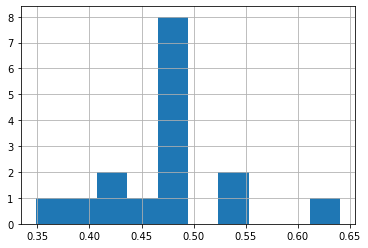

In [14]:
# Взглянем на распределение признака 
plt.hist(data['time_proportion'])
plt.grid();

Гистограмма также подтверждает, что среднее время ```~ 0.5```

Теперь необходимо ответь на вопрос: Есть ли у мышей предпочтения для комнат с зеркалами?

Мы имеем дело с **одной выборкой**, поэтому будем использовать одновыборочные критерии. Самое простое что можно сделать, оценить интервально среднее время провождения в комнате с зеркалом.

### Интервальная оценка среднего

In [15]:
print('95% Confidence Interval For the Mean Time: ', zconfint(data))

95% Confidence Interval For the Mean Time:  (array([0.44291783]), array([0.50765996]))


Видим, что интервал смещен в левую сторону, однако выборочное среднее в него входит. Нужно воспользоваться критериями для проверки гипотез:

$H_0\colon$ медиана доли времени, проведенного в клетке с зеркалом, равна 0.5

$H_1\colon$ медиана доли времени, проведенного в клетке с зеркалом, не равна 0.5

### Критерий Знаков
Воспользуемся готовой функцией ```sign_test()```

In [18]:
res = sign_test(data, 0.5)
print(f'T: {res[0]}, p-value: {round(res[1],4)}')

T: -5.0, p-value: 0.0213


Критерий отвергает нулевую гипотезу, следовательно зеркало как-то влияет на мышей.

### Критерий Ранговых Знаков Уилкоксона

In [19]:
m0 = 0.5
stats.wilcoxon(data['time_proportion'] - m0)

WilcoxonResult(statistic=35.0, pvalue=0.09344482421875)

### Перестановачный Критерий
Изменим гипотезы

$H_0\colon$ среднее равно 0.5

$H_1\colon$ среднее не равно 0.5

Готовой реализации перестановочного критерия нет, поэтому будем реализовывать самостоятельно.

In [51]:
# Функция расчета t - статистики
def permutation_t_stat_1sample(sample, mean):
    t_stat = sum(sample - mean)
    return t_stat

Теперь нам нужно реализовать функцию для подсчета нулевого распределения. Так как в случае, если нулевая гипотеза справедлива и каждый из элементов выборки может с одинаковой вероятностью реализоваться как справа, так и слева от своего среднего, то для получения нулевого распределения нам нужно сделать следующее. 

Нужно взять все элементы выборки, вычесть из них среднее и далее сгенерировать на основе получившейся выборки набор выборок со всеми возможными перестановками знаков перед каждым элементом. Ну понятно, что таких выборок очень много, их ровно 2 в степени n, где n — размер исходной выборки. Поэтому для того, чтобы иметь возможность считать этот критерий быстрее, мы вводим дополнительный параметр ```max_permutations```, то есть максимальное количество перестановок, которые мы хотим перебрать.

В данном случае у нас есть следующая логика. Вместо того чтобы генерировать все возможные комбинации знаков перед элементами выборки, мы с вами сгенерируем только несколько случайных и будем оценивать нулевое распределение относительно сгенерированных случайных выборок

In [52]:
# Функция для расчета нулевого распределения (распределение должно получиться табличным)
def permutation_zero_distr_1sample(sample, mean, max_permutations = None):
    centered_sample = sample - mean
    
    # Если задан, то генерируем случайные выборки со случайными перестановками знаков перед элементами
    # Т.е. для больших выбарок будет достаточно лишь некоторой части перестановок
    if max_permutations:
        # Генерируем знаки (-1, 1)
        signs_array = set([tuple(x) for x in 2 * np.random.randint(2, size = (max_permutations, len(sample))) - 1])
    else:
        signs_array = itertools.product([-1, 1], repeat = len(sample))
        
    zero_distribution = [sum(centered_sample * sign) for sign in signs_array]
    
    return zero_distribution

In [53]:
def get_p_value_permutation_test_1sample(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError ('Alternative Not Recognized!!!')
        
    t_stat = round(permutation_t_stat_1sample(sample, mean), 4)
    zero_distribution = permutation_zero_distr_1sample(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return t_stat, round(sum([1 if abs(x) >= abs(t_stat) else 0 for x in zero_distribution]) / len(zero_distribution), 4)
    
    if alternative == 'less':
        return t_stat, round(sum([1 if x <= t_stat else 0 for x in zero_distribution]) / len(zero_distribution), 4)

    if alternative == 'greater':
        return t_stat, round(sum([1 if x >= t_stat else 0 for x in zero_distribution]) / len(zero_distribution), 4)

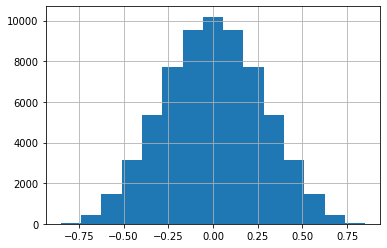

In [54]:
# Взглянем на нулевое распределение 
plt.hist(permutation_zero_distr_1sample(data['time_proportion'], mean = 0.5), bins = 15);
plt.grid()

In [55]:
# p-value для всех возможных перестановок 
p_value_1 = get_p_value_permutation_test_1sample(data['time_proportion'], mean = 0.5, alternative = 'two-sided')
print(f'Statistics: {p_value_1[0]}, p-value: {p_value_1[1]}')

Statistics: -0.3954, p-value: 0.1577


In [56]:
# p-value для 10000 перестановок
p_value_2 = get_p_value_permutation_test_1sample(data['time_proportion'], mean = 0.5, max_permutations = 10000, alternative = 'two-sided')
print(f'Statistics: {p_value_2[0]}, p-value: {p_value_2[1]}')

Statistics: -0.3954, p-value: 0.1603


В случае перестановачных критериев мы не можем отвергнуть нулевую гипотезу